In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import MDAnalysis as md
import torch
import pickle

### load colvar from 1050ns OPES_METAD simulation ->

In [2]:
time, ld1, cleft_dist, dihedral = \
np.loadtxt("/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/run_with_1us_data/COLVAR_EDITED", usecols=(0,1,2,3), unpack=True)

time *= 1e-3 # in ns

### load trajectory data from 1050ns OPES_METAD simulation ->

In [3]:
# read trajectory data
path = "/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/run_with_1us_data"
atoms_selection = "name CA"
print("selected atoms:", atoms_selection)

# load data
prmtopFileName =  path + "/s1_init_protein_only.gro"
trajFiles = [path+"/opes_ld1_bf_12.0_barrier_15.0_wrapped_protein_only.trr"]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName,trajFiles)
sel_atoms = coord.select_atoms(atoms_selection)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_atoms.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_atoms.n_atoms,3),dtype=float)
count = 0

# no need to multiply by 10
for ts in coord.trajectory:
    trajData[count,:,:] = sel_atoms.positions - sel_atoms.center_of_geometry()
    count += 1

selected atoms: name CA
['/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/run_with_1us_data/opes_ld1_bf_12.0_barrier_15.0_wrapped_protein_only.trr']
1
Number of atoms in trajectory: 5835
Number of frames in trajectory: 21001
Number of atoms being analyzed: 375
Number of frames being analyzed: 21001


### load FEs from 900ns and 1050ns STATES files ->

In [4]:
ld1_grids = np.linspace(-41.0, 41.0, 100, endpoint=True)
dihedral_grids = np.linspace(-np.pi, np.pi, 100, endpoint=True)
print(ld1_grids.shape)

# load the final FE from final STATE file  (time=1050ns)
fe_state_final = \
np.loadtxt("/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/run_with_1us_data/2d_fe_actin_ld1+dihedral.dat", usecols=2).reshape([100,100])/4.184
print(fe_state_final.shape)

# load the final FE from final STATE file  (time=1050ns)
fe_state_final_900ns = \
np.loadtxt("/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/run_with_1us_data/2d_fe_actin_ld1+dihedral_900ns.dat", usecols=2).reshape([100,100])/4.184
print(fe_state_final_900ns.shape)

(100,)
(100, 100)
(100, 100)


### $\textbf{Get the fbias weights for each frame from final free energy.}$

In [5]:
kt = 0.616033   # @T=310K in kcal/molK unit

# get the final bias weights 
x_indx = np.digitize(ld1, ld1_grids, right=True)
y_indx = np.digitize(dihedral, dihedral_grids, right=True)

weights = np.empty(time.shape[0])
for i in range(time.shape[0]):
    weights[i] = np.exp(-fe_state_final.T[x_indx[i], y_indx[i]]/kt)

### $ \textbf{load 5 Clusters gmm object for actin obtained later with huge amount of data }$

In [6]:
with open("/scratch/projects/hockygroup/ss12902/posLDA_actin\
/cluster_opes_data_from_triasha/run_with_v1.6.1/wrapped_trajs_for_actin/wsgmm_5state_all_data_copy_testing.pickle", "rb") as f_o:
    wsgmm5 = pickle.load(f_o)

print(wsgmm5.weights)
print(wsgmm5.cluster_ids.shape)

[0.47558577 0.24211659 0.17438502 0.06351644 0.04439619]
(153564,)


###  wSGMM5 to predict the cluster identity on 1050ns OPES_METAD data ->

In [7]:
wsgmm5.device = torch.device("cpu")
cluster_ids_predicted, _, _ = wsgmm5.predict(trajData, frame_weights = weights[::50])
print(cluster_ids_predicted.shape)

(21001,)


### Definition of different subdomains of actin monomer from Paper -->

In [8]:
# 1-based indexing here
b1_range = [[5,33], [80,147], [334,349]]
b2_range = [[34,39], [52,69]]
b3_range = [[148,179], [273,333]]
b4_range = [[180, 219],[252,262]]

subdomains = [b1_range, b2_range, b3_range, b4_range]

# will keep this as 0-based indexing
residue_indices = []

# loop over domains
for i in range(len(subdomains)):
    
    x = subdomains[i]
    indx_list = []
    
    # loop over ranges in domain 
    for j in range(len(x)):
        a = np.arange(x[j][0], x[j][1]+1) - 1  # subtracting 1 to make it 0-based. 
        indx_list.append(a)    
    indx_list = np.concatenate(indx_list, axis=0)
    
    residue_indices.append(indx_list)
#print(residue_indices)    

### get the positions of cluster centers on cleft dist and dihedral space 

In [9]:
cluster_indx = []
for i in range(wsgmm5.n_clusters):
    indx = [x[0] for x in np.argwhere(cluster_ids_predicted == i)]
    cluster_indx.append(indx)
    print(len(indx))

dihedral_centers = [np.mean(dihedral[::50][cluster_indx[i]])*180/3.14 for i in range(wsgmm5.n_clusters)]
cleft_dist_centers = [np.mean(cleft_dist[::50][cluster_indx[i]])*10.0 for i in range(wsgmm5.n_clusters)]
ld1_centers = [np.mean(ld1[::50][cluster_indx[i]]) for i in range(wsgmm5.n_clusters)]

3501
1531
4194
11479
296


### $\textbf{ Get 2D FES on $d$ and $\phi$ space by reweighting using fbias frame weights.}$

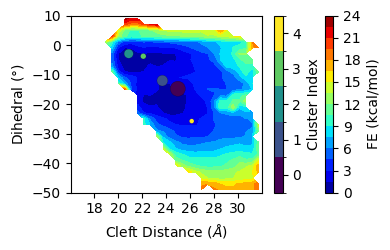

In [10]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("viridis", wsgmm5.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm5.n_clusters+1), cmap.N)

# get the FE
hist, xedges, yedges = np.histogram2d(cleft_dist*10.0, dihedral*180/3.14, bins=[30,30], range=[[16,32],[-50,10]], density=True, weights=weights)
xbins = (xedges[1:] + xedges[:-1])/2.0
ybins = (yedges[1:] + yedges[:-1])/2.0

fe = -kt*np.log(hist)
fe -= fe.min()

xx,yy = np.meshgrid(xbins, ybins)
plt.figure(figsize=(4,2.6), dpi=100)
plt.xticks([18,20,22,24,26,28,30])
plt.xlim(16,32)
plt.ylim(-50,10)
plt.xlabel("Cleft Distance ($\\AA$)")
plt.ylabel("Dihedral ($\\degree$)")

im1 = plt.contourf(xx, yy, fe.T, cmap="jet", levels=20)
cbar_1 = plt.colorbar(im1)
cbar_1.set_label("FE (kcal/mol)")

im2 = plt.scatter(cleft_dist_centers, dihedral_centers, c=np.arange(wsgmm5.n_clusters), cmap=cmap, norm=norm, marker="o", s=wsgmm5.weights*250.0, edgecolor="k", linewidth=0.1)
cbar_2 = plt.colorbar(im2)
cbar_2.set_ticks(np.arange(0.5, wsgmm5.n_clusters,1))
cbar_2.set_ticklabels(np.arange(wsgmm5.n_clusters))
cbar_2.set_label("Cluster Index")

plt.tight_layout()
plt.savefig("2d_fes_opes_1050ns_data.pdf", format="pdf")

### $\textbf{Plot the FE from 900ns / 1050ns STATES file.}$

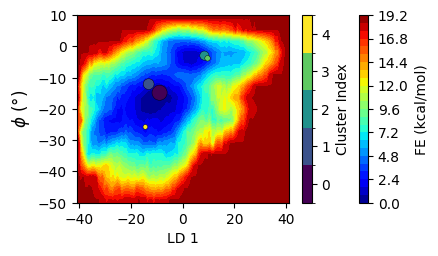

In [11]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("viridis", wsgmm5.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm5.n_clusters+1), cmap.N)

plt.figure(figsize=(4.2,2.5), dpi=100)
plt.ylim(-50.0,10)
plt.xlabel("LD 1")
#plt.ylabel("Dihedral ($\\degree$)")
plt.ylabel("$\phi$ ($\\degree$)", fontsize=12)

# 900ns FES
im1 = plt.contourf(ld1_grids, dihedral_grids*180/3.14, fe_state_final_900ns, cmap="jet", levels=25)

# 1050ns FES
#im1 = plt.contourf(ld1_grids, dihedral_grids*180/3.14, fe_state_final, cmap="jet", levels=25)

cbar_1 = plt.colorbar(im1)
cbar_1.set_label("FE (kcal/mol)")

im2 = plt.scatter(ld1_centers, dihedral_centers, marker="o", c=np.arange(wsgmm5.n_clusters), s=wsgmm5.weights*250, cmap=cmap, norm=norm, edgecolor="k", linewidth=0.30)
cbar_2 = plt.colorbar(im2)
cbar_2.set_ticks(np.arange(0.5, wsgmm5.n_clusters,1))
cbar_2.set_ticklabels(np.arange(wsgmm5.n_clusters))
cbar_2.set_label("Cluster Index")

plt.subplots_adjust(left=0.16, right=0.95, bottom=0.2, top=0.95)

#plt.savefig("2d_fes_opes_1050ns_data_ld1_vs_dihedral_updated.pdf", format="pdf")
plt.savefig("2d_fes_opes_900ns_data_ld1_vs_dihedral_updated.pdf", format="pdf")

### $\textbf{ plot LD and $\phi$ vs. Time}$

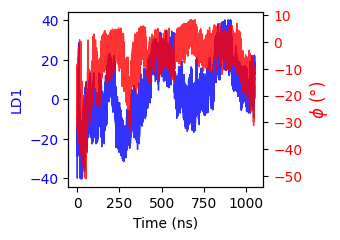

In [12]:
fig, axs = plt.subplots(1,1, figsize=(3.5,2.5))

axs.plot(time, ld1, color="blue", lw=1.0, alpha=0.8)
axs.set_xticks(np.arange(0,1250,250))
axs.set_xlabel("Time (ns)")
axs.set_ylabel("LD1", color="blue")
axs.tick_params(axis='y', labelcolor="blue")

y1 = axs.twinx()
y1.set_yticks(np.arange(-50,20,10))
y1.tick_params(axis='y', labelcolor="red")
y1.set_ylabel("$\phi$ ($\\degree$)", fontsize=12, color="red")
y1.plot(time, dihedral*180/3.14, color="red", lw=1.0, alpha=0.8)

plt.tight_layout()
plt.savefig("lda_and_dihedral_vs_time.pdf", format="pdf")

### $\textbf{Load the training and cross validation data from cluster scans.}$

In [13]:
# load the files from OPES (using fbias weights)
train_fbias_opes = np.loadtxt(path+"/train_fbias.dat")[:,1:]
cv_fbias_opes = np.loadtxt(path+"/cv_fbias.dat")[:,1:]

train_fbias_opes_mean = np.mean(train_fbias_opes, axis=1)
train_fbias_opes_std = np.std(train_fbias_opes, axis=1)

cv_fbias_opes_mean = np.mean(cv_fbias_opes, axis=1)
cv_fbias_opes_std = np.std(cv_fbias_opes, axis=1)


# load the files from restarted OPES (using fbias weights)
train_fbias_opes_rst = np.loadtxt(path+"/../wrapped_trajs_for_actin/train_all_data_copy_testing.dat")[:,1:]
cv_fbias_opes_rst = np.loadtxt(path+"/../wrapped_trajs_for_actin/cv_all_data_copy_testing.dat")[:,1:]

train_fbias_opes_rst_mean = np.mean(train_fbias_opes_rst, axis=1)
train_fbias_opes_rst_std = np.std(train_fbias_opes_rst, axis=1)

cv_fbias_opes_rst_mean = np.mean(cv_fbias_opes_rst, axis=1)
cv_fbias_opes_rst_std = np.std(cv_fbias_opes_rst, axis=1)

### make cluster scan figure (comparing OPES and restarted OPES)

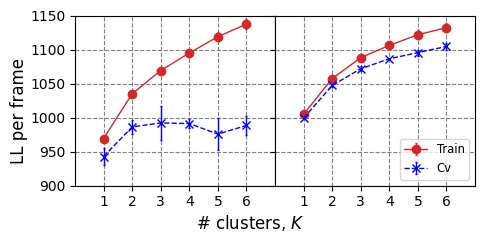

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(5,2.5), sharex=True, sharey=True)
fig.supxlabel("# clusters, $K$")
fig.supylabel("LL per frame")

#0
# set lims
axs[0].set_xlim(0,7)
axs[0].set_ylim(900,1150)
    
# set y-ticks
axs[0].set_yticks(np.arange(900,1200,50))
axs[0].set_yticklabels(np.arange(900,1200,50))
    
# set x-ticks
axs[0].set_xticks(np.arange(1,7))
axs[0].set_xticklabels(np.arange(1,7))


#axs[0].set_title("#frames = 20791")
axs[0].grid(which='major', axis='both', color='#808080', linestyle='--')
axs[0].errorbar(np.arange(1,7), train_fbias_opes_mean, train_fbias_opes_std, fmt='-o', color="tab:red", lw=1, capsize=1, label="Train")
axs[0].errorbar(np.arange(1,7), cv_fbias_opes_mean, cv_fbias_opes_std, fmt='--x', color="blue", lw=1, capsize=1, label="Cv")

#1
#axs[1].set_title("#frames = 138208")
axs[1].grid(which='major', axis='both', color='#808080', linestyle='--')
axs[1].errorbar(np.arange(1,7), train_fbias_opes_rst_mean, train_fbias_opes_rst_std, fmt='-o', color="tab:red", lw=1, capsize=1, label="Train")
axs[1].errorbar(np.arange(1,7), cv_fbias_opes_rst_mean, cv_fbias_opes_rst_std, fmt='--x', color="blue", lw=1, capsize=1, label="Cv")
axs[1].legend(loc="lower right", fontsize="small")

plt.subplots_adjust(wspace=0, left=0.15, bottom=0.20, right=0.95)

plt.savefig("compare_scans.pdf", format="pdf")

### $ \textbf{Generate 1M samples from wSGMM to estimate FE}$

### functions for generating synthetic trajectory -->

In [15]:
from scipy.stats import multivariate_normal

def gen_trj_cluster(cluster_mean, cluster_covariance, scale=1, N_samples=10000):
    rv = multivariate_normal(mean=cluster_mean.flatten(), cov=cluster_covariance*scale, allow_singular=True)
    trj = rv.rvs(size=N_samples).reshape(N_samples, -1, 3)
    return cluster_mean, trj

def pseudo_inv(mat,remove):
    # it calculates the pseudo inverse of a singular matrix
    e, v = np.linalg.eigh(mat)
    e[remove:] = 1/e[remove:]
    e[:remove] = 0.00
    return np.dot(v,np.dot(np.diag(e),v.T))

In [16]:
# population of clusters ->
print("population in % :", [i for i in wsgmm5.weights*100])

population in % : [47.558576546721795, 24.21165913011418, 17.438501668073332, 6.3516437622846516, 4.439618892806032]


In [17]:
# load
trjs_combined = np.load("synthetic_trajdata_actin_5clusters_copy_testing.npy", allow_pickle=True)
print(trjs_combined.shape)

(1049999, 375, 3)


In [18]:
new_data_synthetic = np.empty([trjs_combined.shape[0], 4, 3])

# loop over domains
for i in range(4):
    
    # ith domain
    bi = trjs_combined[:,residue_indices[i], :]
    bi_com = np.mean(bi, axis=1)
    
    new_data_synthetic[:,i,:] = bi_com

In [19]:
from MDAnalysis.lib.distances import calc_dihedrals

dihedral_synthetic = calc_dihedrals(new_data_synthetic[:,1,:], new_data_synthetic[:,0,:], new_data_synthetic[:,2,:], new_data_synthetic[:,3,:])*180/3.14
cleft_dist_synthetic = np.sqrt(np.sum(np.square(new_data_synthetic[:,1,:] - new_data_synthetic[:,3,:]), axis=1))

### load the FE from restarted data 
Obtained by reweighting using fbias frame weights (including wall bias of course!)

In [20]:
fe_rst_data = np.load("fe_rst_data.npy", allow_pickle=True)
print(fe_rst_data.shape)

(30, 30)


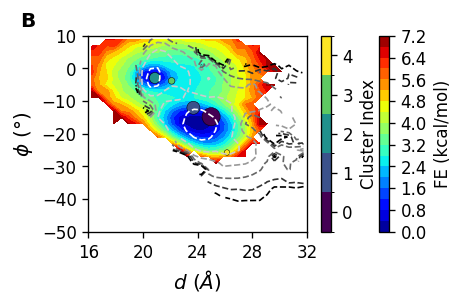

In [21]:
import string 
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("viridis", wsgmm5.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm5.n_clusters+1), cmap.N)

kt=0.616033 # in kcal/mol unit
hist, xedges, yedges = np.histogram2d(cleft_dist_synthetic, dihedral_synthetic, bins=[30,30], range=[[16,32],[-50,10]], density=True)
xbins = (xedges[1:] + xedges[:-1])/2.0
ybins = (yedges[1:] + yedges[:-1])/2.0

fe_gmm_syn = -kt*np.log(hist)
fe_gmm_syn -= fe_gmm_syn.min()

xx,yy = np.meshgrid(xbins, ybins)
plt.figure(figsize=(3.8,2.4), dpi=120)
plt.xticks(np.arange(16,36,4))
plt.yticks(np.arange(-50,20,10))
plt.xlim(16,32)
plt.ylim(-50,10)
#plt.xlabel("Cleft Distance ($\\AA$)")
#plt.ylabel("Dihedral ($\\degree$)")
plt.xlabel("$d$ ($\\AA$)", fontsize=12)
plt.ylabel("$\phi$ ($\\degree$)", fontsize=12)
plt.text(11, 12.8, string.ascii_uppercase[1], fontsize=12, fontweight="bold")
im1 = plt.contourf(xx, yy, fe_gmm_syn.T, cmap="jet", levels=20)
cbar_1 = plt.colorbar(im1)
cbar_1.set_label("FE (kcal/mol)")

im2 = plt.scatter(cleft_dist_centers, dihedral_centers, c=np.arange(wsgmm5.n_clusters), cmap=cmap, norm=norm, marker="o", s=wsgmm5.weights*250.0, edgecolor="k", linewidth=0.3)
cbar_2 = plt.colorbar(im2)
cbar_2.set_ticks(np.arange(0.5, wsgmm5.n_clusters,1))
cbar_2.set_ticklabels(np.arange(wsgmm5.n_clusters))
cbar_2.set_label("Cluster Index")

#plt.contour(xx, yy, fe.T, cmap="binary", levels=np.arange(1,13,2), linestyles="--", linewidths=1.0)
plt.contour(xx, yy, fe_rst_data.T, cmap="binary", levels=np.arange(1,13,2), linestyles="--", linewidths=1)

plt.subplots_adjust(left=0.20, right=0.95, bottom=0.2)
plt.savefig("actin_2d_gen_fes_with_contour_lines.pdf", format="pdf")